In [1]:
!pip install torch torchvision matplotlib -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

# load image data
train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=512, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 627kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


In [3]:
class VGG11(nn.Module):
  # VGG11 architecture
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1,64,3,1,1),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(64,128,3,1,1),nn.BatchNorm2d(128),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(128,256,3,1,1),nn.BatchNorm2d(256),nn.ReLU(),
      nn.Conv2d(256,256,3,1,1),nn.BatchNorm2d(256),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(256,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),
      nn.Conv2d(512,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(512,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),
      nn.Conv2d(512,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),nn.MaxPool2d(2,2),
    )
    self.classifier = nn.Sequential(
      nn.Linear(512,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,10)
    )
  def forward(self,x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
epochs = 3
train_acc = []
test_acc = []
train_loss = []
test_loss = []

for epoch in range(epochs):
  # train
  model.train()
  correct=0
  total=0
  running_loss=0
  for x,y in train_loader:
    x=x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out,y)
    loss.backward(); optimizer.step()
    running_loss += loss.item()*y.size(0)
    _,preds = out.max(1)
    total+=y.size(0)
    correct+=preds.eq(y).sum().item()
  train_loss.append(running_loss/total)
  train_acc.append(correct/total)

  # test
  model.eval()
  correct=0
  total=0
  running_loss=0
  for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    out = model(x)
    loss = criterion(out,y)
    running_loss += loss.item()*y.size(0)
    _,preds = out.max(1)
    total+=y.size(0)
    correct+=preds.eq(y).sum().item()
  test_loss.append(running_loss/total)
  test_acc.append(correct/total)

  print("Epoch " + str(epoch+1) + ":")
  print("Train acc = "+str(train_acc[-1]))
  print("Train loss = "+str(train_loss[-1]))
  print("Test acc = "+str(test_acc[-1]))
  print("Test loss = "+str(test_loss[-1]))



Epoch 1:
Train acc = 0.6494666666666666
Train loss = 0.9732272394180298
Test acc = 0.9489
Test loss = 0.175637335729599
Epoch 2:
Train acc = 0.9683833333333334
Train loss = 0.11232447169621786
Test acc = 0.9771
Test loss = 0.07105859229564666
Epoch 3:
Train acc = 0.9854166666666667
Train loss = 0.053402714997529986
Test acc = 0.9597
Test loss = 0.1291555983543396


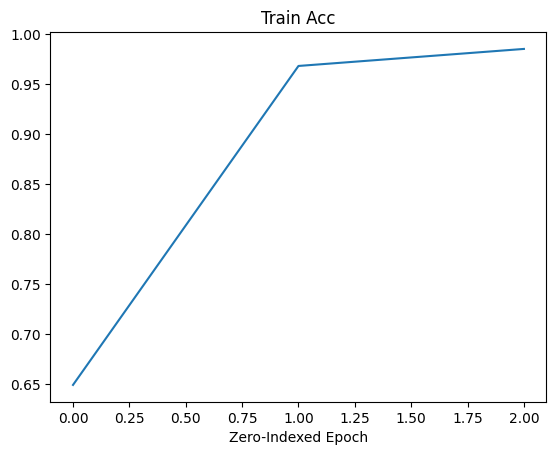

In [5]:
plt.plot(train_acc)
plt.xlabel("Zero-Indexed Epoch")
plt.title("Train Acc")
plt.show()

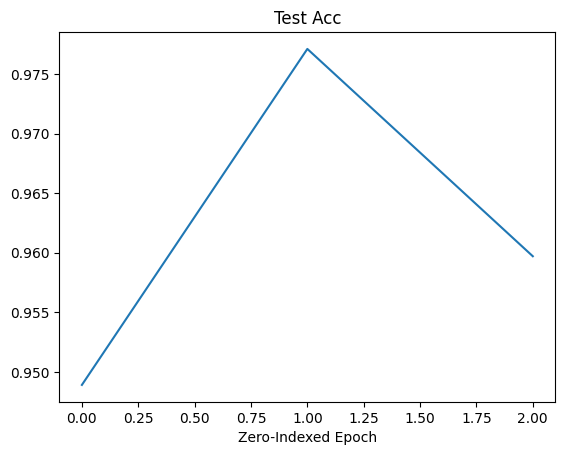

In [6]:
plt.plot(test_acc)
plt.xlabel("Zero-Indexed Epoch")
plt.title("Test Acc")
plt.show()

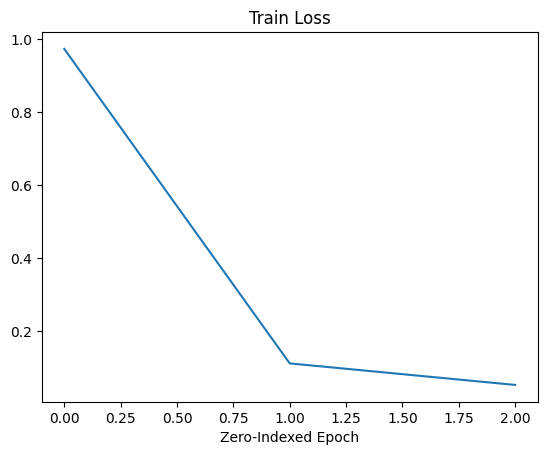

In [7]:
plt.plot(train_loss)
plt.xlabel("Zero-Indexed Epoch")
plt.title("Train Loss")
plt.show()

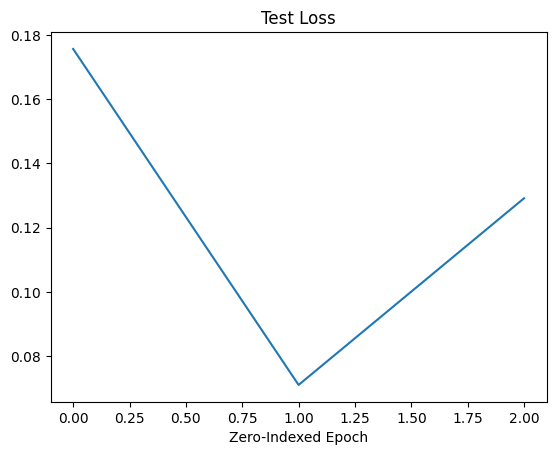

In [8]:
plt.plot(test_loss)
plt.xlabel("Zero-Indexed Epoch")
plt.title("Test Loss")
plt.show()

In [9]:
def eval_transform(t):
  """
  t: a torchvision transform
  returns the accuracy of the model on the test set after applying the transform
  """
  test_t = datasets.MNIST("./data", train=False, download=False, transform=transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), t]))
  loader = DataLoader(test_t, batch_size=512)
  model.eval()
  correct=0
  total=0
  for x,y in loader:
    x = x.to(device)
    y = y.to(device)
    _,preds = model(x).max(1)
    total+=y.size(0)
    correct+=preds.eq(y).sum().item()
  return correct/total

print("Horizontal flip test acc:", eval_transform(transforms.RandomHorizontalFlip(p=1)))
print("Vertical flip test acc:", eval_transform(transforms.RandomVerticalFlip(p=1)))

Horizontal flip test acc: 0.2638
Vertical flip test acc: 0.2919


In [10]:
import math
# evaluate model accuracy under gaussian noise
for var in [0.01, 0.1, 1.0]:
  noise = transforms.Lambda(lambda x: x + math.sqrt(var)*torch.randn_like(x))
  acc = eval_transform(noise)
  print("Test accuracy with with variance " + str(var) + " = " + str(acc))

Test accuracy with with variance 0.01 = 0.9027
Test accuracy with with variance 0.1 = 0.4291
Test accuracy with with variance 1.0 = 0.1024


In [11]:
import random

# evaluate model accuracy under random translations and gaussian noise
aug = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # no rotation + small random shifts
  transforms.ToTensor(),
  transforms.Lambda(lambda x: x + random.uniform(0.0, 0.1)*torch.randn_like(x)) # small random Gaussian noise
])

aug_set = datasets.MNIST("./data", train=True, download=False, transform=aug)
aug_loader = DataLoader(aug_set, batch_size=512, shuffle=True)

model2 = VGG11().to(device)
opt2 = optim.Adam(model2.parameters(), lr=0.001)

for epoch in range(3):
  model2.train()
  for x,y in aug_loader:
    x = x.to(device)
    y = y.to(device)
    opt2.zero_grad()
    out = model2(x)
    loss = criterion(out,y)
    loss.backward()
    opt2.step()

  model2.eval()
  correct=0
  total=0
  for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    _,preds = model2(x).max(1)
    total+=y.size(0)
    correct+=preds.eq(y).sum().item()

  print("Epoch " + str(epoch+1) + " test accuracy for augmented data: " + str(correct/total))

Epoch 1 test accuracy for augmented data: 0.9105
Epoch 2 test accuracy for augmented data: 0.9794
Epoch 3 test accuracy for augmented data: 0.9835
